In [1]:
import os
import sys
sys.path.insert(0, os.path.relpath('../../../../../../'))

from importlib import reload
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from recidiviz.calculator.modeling.population_projection.simulations.super_simulation_factory import SuperSimulationFactory
from recidiviz.calculator.modeling.population_projection.shell_compartment import ShellCompartment
from recidiviz.calculator.modeling.population_projection.spark_policy import SparkPolicy


In [2]:
test_sim = SuperSimulationFactory.build_super_simulation('../../state/IL/IL_prison_TIS_model_inputs.yaml')
# test_sim.simulate_baseline('pretrial', 'prison')

/Users/pacopoler/.local/share/virtualenvs/pulse-data-Jd9N3JcA/lib/python3.7/site-packages/google/cloud/bigquery/table.py:1728: UserWarning: A progress bar was requested, but there was an error loading the tqdm library. Please install tqdm to use the progress bar functionality.
  create_bqstorage_client=create_bqstorage_client,


outflows_data returned 648 results
transitions_data returned 416 results
total_population_data returned 648 results


initialization time:  0.05965375900268555
simulation_time:  77.5268669128418
initialization time:  0.04174685478210449
simulation_time:  72.74173331260681


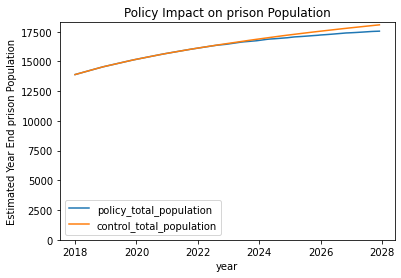

In [3]:
races = ['white', 'non-white']
tis_percentages = {
    '100%': 1, 
    '85%': 0.85, 
    '75%': 0.75, 
}

icjsrc_percentages = {
    '100%': 0.9,
    '85%': 0.75,
    '75%': 0.6
}

aclu_percentages = {
    '100%': 0.75,
    '85%': 0.72,
    '75%': 0.5
}


# Policy Option Methods
def reduce_tis_percentage_aclu(tis_percentage, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'probation': 1 - aclu_percentages[tis_percentage] / tis_percentages[tis_percentage]}, 
                   reduction_type='*',
                   retroactive=retroactive
                  )

def reduce_tis_percentage_icjsrc(tis_percentage, retroactive=False):
    return partial(CompartmentTransitions.apply_reduction, 
                   reduction_dict={'probation': 1 - icjsrc_percentages[tis_percentage] / tis_percentages[tis_percentage]}, 
                   reduction_type='*',
                   retroactive=retroactive
                  )

policy_list_non_retroactive_aclu = list()
policy_list_non_retroactive_icjsrc = list()

for tis_percentage in tis_percentages:
    for race in races:
        policy_list_non_retroactive_aclu.append(SparkPolicy(
            policy_fn=reduce_tis_percentage_aclu(tis_percentage),
            spark_compartment='prison',
            sub_population={'tis_percentage': tis_percentage, 'race': race},
            apply_retroactive=False)
        )
        
        policy_list_non_retroactive_icjsrc.append(SparkPolicy(
            policy_fn=reduce_tis_percentage_icjsrc(tis_percentage),
            spark_compartment='prison',
            sub_population={'tis_percentage': tis_percentage, 'race': race},
            apply_retroactive=False)
        )
    
test_results = test_sim.simulate_policy(policy_list_non_retroactive_aclu, 'prison')

In [4]:
simulation_tag = 'IL_truth_in_sentencing_aclu'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

     year compartment     total_cost  month  day
0    2017      prison       0.000000     12    1
1    2018      prison       0.000000      1    1
2    2018      prison       0.000000      2    1
3    2018      prison       0.000000      3    1
4    2018      prison       0.000000      4    1
..    ...         ...            ...    ...  ...
355  2027   probation -221194.572832      7    1
356  2027   probation -227634.308698      8    1
357  2027   probation -234123.397365      9    1
358  2027   probation -240698.113151     10    1
359  2027   probation -247335.059966     11    1

[360 rows x 5 columns]



/Users/pacopoler/.local/share/virtualenvs/recidiviz-research-LWZgHH0n/lib/python3.7/site-packages/google/auth/_default.py:69: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK. We recommend that most server applications use service accounts instead. If your application continues to use end user credentials from Cloud SDK, you might receive a "quota exceeded" or "API not enabled" error. For more information about service accounts, see https://cloud.google.com/docs/authentication/
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


     year compartment   life_years  month  day
0    2017      prison     0.000000     12    1
1    2018      prison     0.000000      1    1
2    2018      prison     0.000000      2    1
3    2018      prison     0.000000      3    1
4    2018      prison     0.000000      4    1
..    ...         ...          ...    ...  ...
355  2027   probation -1061.750938      7    1
356  2027   probation -1092.662164      8    1
357  2027   probation -1123.810288      9    1
358  2027   probation -1155.369429     10    1
359  2027   probation -1187.227283     11    1

[360 rows x 5 columns]

     year compartment                  scenario    population  month  day
0    2017      prison   policy_total_population  13894.681501     12    1
1    2018      prison   policy_total_population  13954.359881      1    1
2    2018      prison   policy_total_population  14014.035160      2    1
3    2018      prison   policy_total_population  14073.707582      3    1
4    2018      prison   policy_total_popu

initialization time:  0.04230976104736328
simulation_time:  67.88764500617981
initialization time:  0.03793907165527344
simulation_time:  64.47102904319763


(                   prison  release      probation
 year                                             
 2018.000000  0.000000e+00      0.0       0.000000
 2018.083333  0.000000e+00      0.0       0.000000
 2018.166667  0.000000e+00      0.0       0.000000
 2018.250000  0.000000e+00      0.0       0.000000
 2018.333333  0.000000e+00      0.0       0.000000
 ...                   ...      ...            ...
 2027.583333  2.655502e+06     -0.0 -158555.991654
 2027.666667  2.750810e+06     -0.0 -163367.659809
 2027.750000  2.848146e+06     -0.0 -168152.408868
 2027.833333  2.947415e+06     -0.0 -172905.606368
 2027.916667  3.048604e+06     -0.0 -177626.746207
 
 [120 rows x 3 columns],
                  prison     release   probation
 year                                           
 2018.000000    0.000000    0.000000    0.000000
 2018.083333    0.000000    0.000000    0.000000
 2018.166667    0.000000    0.000000    0.000000
 2018.250000    0.000000    0.000000    0.000000
 2018.333333    

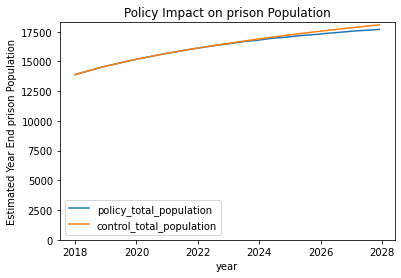

In [5]:
test_sim.simulate_policy(policy_list_non_retroactive_icjsrc, 'prison')

In [6]:
simulation_tag = 'IL_truth_in_sentencing_icjsrc'
test_sim.upload_simulation_results_to_bq('recidiviz-staging', simulation_tag)

     year compartment     total_cost  month  day
0    2017      prison       0.000000     12    1
1    2018      prison       0.000000      1    1
2    2018      prison       0.000000      2    1
3    2018      prison       0.000000      3    1
4    2018      prison       0.000000      4    1
..    ...         ...            ...    ...  ...
355  2027   probation -158555.991654      7    1
356  2027   probation -163367.659809      8    1
357  2027   probation -168152.408868      9    1
358  2027   probation -172905.606368     10    1
359  2027   probation -177626.746207     11    1

[360 rows x 5 columns]

     year compartment  life_years  month  day
0    2017      prison    0.000000     12    1
1    2018      prison    0.000000      1    1
2    2018      prison    0.000000      2    1
3    2018      prison    0.000000      3    1
4    2018      prison    0.000000      4    1
..    ...         ...         ...    ...  ...
355  2027   probation -761.080937      7    1
356  2027   probati